In [1]:
#pragma cling add_include_path("/home/mark/local/mark-vtk-m/include/vtkm-1.0/")
#pragma cling add_library_path("/home/mark/local/mark-vtk-m/lib/")
#pragma cling load("vtkm_cont-1.0")
#pragma cling load("vtkm_rendering-1.0")
#include <vtkm/cont/DeviceAdapter.h>
#include <vtkm/cont/testing/MakeTestDataSet.h>
#include <vtkm/cont/testing/Testing.h>
#include <vtkm/rendering/Actor.h>
#include <vtkm/rendering/CanvasPathTracer.h>
#include <vtkm/rendering/MapperPathTracer.h>
#include <vtkm/rendering/Scene.h>
#include <vtkm/rendering/View3D.h>
#include <vtkm/rendering/testing/RenderTest.h>
#pragma cling add_include_path("/home/mark/local/anaconda3/envs/cling/include")
#pragma cling add_library_path("/home/mark/local/anaconda3/envs/cling/lib")
#pragma cling load("vtkCommonCore-8.2")
#pragma cling load("vtkRenderingCore-8.2")
#pragma cling load("libvtkIOLegacy-8.2")
#pragma cling load("vtkCommonColor-8.2")
#pragma cling load("vtkCommonCore-8.2")
#pragma cling load("vtkCommonDataModel-8.2")
#pragma cling load("vtkFiltersSources-8.2")
#pragma cling load("vtkInteractionStyle-8.2")
#pragma cling load("vtkRenderingFreeType-8.2")
#pragma cling load("vtkIOXML-8.2")

#include <vtk/vtkSphereSource.h>
#include <vtk/vtkPolyDataWriter.h>
#include <vtk/vtkActor.h>
#include <regex>

using CoordType = vtkm::Vec<vtkm::Float32, 3>;


In file included from input_line_8:6:
/home/mark/local/mark-vtk-m/include/vtkm-1.0/vtkm/rendering/MapperPathTracer.h:62:8: warning: 'RenderStoredCells' overrides a member function but is not marked 'override' [-Winconsistent-missing-override]
  void RenderStoredCells(const vtkm::rendering::Camera& camera);
       ^
/home/mark/local/mark-vtk-m/include/vtkm-1.0/vtkm/rendering/Mapper.h:62:16: note: overridden virtual function is here
  virtual void RenderStoredCells(const vtkm::rendering::Camera& vtkmNotUsed(camera)) {};
               ^


In [2]:
void makeCoords(vtkSmartPointer<vtkSphereSource> &sphereSource,
               std::vector<CoordType> &coords)
{
//     std::regex re("\\s*\\.\\s*");
//     std::smatch base_match;
//     std::regex_search(str, base_match, rgx);
    auto polyData = sphereSource->GetOutput();
    for (int i=0; i<polyData->GetNumberOfPoints(); i++){
        double pt[3];
        polyData->GetPoint(i, pt);
//         std::cout << "coords.push_back(CoordType(";
//         for (int j=0; j<2; j++){
//             std::cout << pt[j] << ", ";
//         }
//         std::cout << pt[2] << "));" << std::endl;
        coords.push_back(CoordType(pt[0], pt[1], pt[2]));
    }
};


In [3]:
void  makeCells(vtkSmartPointer<vtkSphereSource> &sphereSource,
              std::vector<vtkm::UInt8> &shapes,
               std::vector<vtkm::IdComponent> &numindices,
               std::vector<vtkm::Float32> &cellvar,
              std::vector<vtkm::Id> &conn,
               int numPrev) 
{
    auto polyData = sphereSource->GetOutput();

    auto polys = polyData->GetPolys();
   vtkIdType numCells = polys->GetNumberOfCells();
   vtkIdType cellLocation = 0; // the index into the cell array
   for (vtkIdType i = 0; i < numCells; i++)
    {
    vtkIdType numIds; // to hold the size of the cell
    vtkIdType *pointIds; // to hold the ids in the cell

    polys->GetCell(cellLocation, numIds, pointIds);
    cellLocation += 1 + numIds;
//     std::cout << "shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE); numindices.push_back(3); cellvar.push_back(0.0);" << std::endl;
//     for (int j=0; j<3; j++){
//        std::cout << "conn.push_back(" << pointIds[j] << "); ";
//     }
//     std::cout << std::endl;
       shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE); numindices.push_back(3); cellvar.push_back(0.0);
       for (int j=0; j<3; j++){
           conn.push_back(numPrev + pointIds[j]);
       }
   
  }
}


In [4]:
void createSphere(int theta, int phi, vtkm::Float32 radius, vtkm::Vec<vtkm::Float32, 3> center,
                                std::vector<CoordType> &coords, 
                                std::vector<vtkm::Float32>& cellvar, 
                                std::vector<vtkm::UInt8> &shapes, 
                                std::vector<vtkm::IdComponent> &numindices, 
                                std::vector<vtkm::Id> &conn)
{
    auto sphereSource = vtkSmartPointer<vtkSphereSource>::New();
    
    sphereSource->SetCenter(center[0],center[1],center[2]);
    sphereSource->SetRadius(radius);
    sphereSource->SetThetaResolution(theta);
    sphereSource->SetPhiResolution(phi);
    
    auto writer = vtkSmartPointer<vtkPolyDataWriter>::New();
    writer->SetInputConnection(sphereSource->GetOutputPort());
    writer->SetFileName("sphere.vtk");
    writer->Update();

    int prevCnt = coords.size();
    makeCoords(sphereSource, coords);
    makeCells(sphereSource, shapes, numindices, cellvar, conn, prevCnt);
}

In [5]:
vtkm::cont::DataSet createSphere(int theta, int phi, vtkm::Float32 radius, vtkm::Vec<vtkm::Float32, 3> center)
{


  std::vector<CoordType> coords;
  std::vector<vtkm::Float32> cellvar;

  std::vector<vtkm::UInt8> shapes;
  std::vector<vtkm::IdComponent> numindices;
  std::vector<vtkm::Id> conn;
    
    createSphere(theta, phi, radius, center, coords, cellvar, shapes, numindices, conn);

  vtkm::cont::DataSet dataSet;
  vtkm::cont::DataSetBuilderExplicit dsb;
  vtkm::cont::DataSetFieldAdd dsf;
  dataSet = dsb.Create(coords, shapes, numindices, conn, "coordinates", "cells");

  dsf.AddCellField(dataSet, "cellvar", cellvar, "cells");

  return dataSet;
}


In [6]:
void tris(
  std::vector<vtkm::Float32> &cellvar,
  std::vector<vtkm::UInt8> &shapes,
  std::vector<vtkm::IdComponent> &numindices,
  std::vector<vtkm::Id> &conn,
    const vtkm::UInt32 &numspheres)
{
  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(0.0);
  conn.push_back(numspheres +0);conn.push_back(numspheres +1);  conn.push_back(numspheres +2);
  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(0.0);
  conn.push_back(numspheres +0);conn.push_back(numspheres +2);conn.push_back(numspheres +3);

  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(.0);
  conn.push_back(numspheres +4);  conn.push_back(numspheres +5);  conn.push_back(numspheres +6);
  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(.0);
  conn.push_back(numspheres +4);  conn.push_back(numspheres +6);  conn.push_back(numspheres +7);


//   shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(1.0);
//   conn.push_back(numspheres +8);  conn.push_back(numspheres +9);  conn.push_back(numspheres +10);
//   shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(1.0);
//   conn.push_back(numspheres +8);  conn.push_back(numspheres +10);  conn.push_back(numspheres +11);

  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(0.0);
  conn.push_back(numspheres +12);  conn.push_back(numspheres +13);  conn.push_back(numspheres +14);
  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(0);
  conn.push_back(numspheres +12);  conn.push_back(numspheres +14);  conn.push_back(numspheres +15);


  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(0.0);
  conn.push_back(numspheres +16);  conn.push_back(numspheres +17);  conn.push_back(numspheres +18);
  shapes.push_back(vtkm::CELL_SHAPE_TRIANGLE);  numindices.push_back(3);  cellvar.push_back(.0);
  conn.push_back(numspheres +16);  conn.push_back(numspheres +18);conn.push_back(numspheres +19);
}


In [7]:
inline void makeBox(std::vector<CoordType> &coords,
                                   std::vector<vtkm::Float32> &cellvar,
                                   std::vector<vtkm::UInt8> &shapes,
  std::vector<vtkm::IdComponent> &numindices,
  std::vector<vtkm::Id> &conn
    )
{

int numspheres = coords.size();
  auto makePoint = [&](CoordType _c){coords.push_back(_c);};


  makePoint(CoordType(0.f,  0.f, 0.f));
  makePoint(CoordType(5.f,  0.f, 0.f));
  makePoint(CoordType(5.f,  8.f, 0.f));
  makePoint(CoordType(0.f,  8.f, 0.f));

  makePoint(CoordType(0.f,  0.f, 5.f));
  makePoint(CoordType(5.f,  0.f, 5.f));
  makePoint(CoordType(5.f,  8.f, 5.f));
  makePoint(CoordType(0.f,  8.f, 5.f));

  makePoint(CoordType(0.f,  8.f, 0.f));
  makePoint(CoordType(5.f,  8.f, 0.f));
  makePoint(CoordType(5.f,  8.f, 5.f));
  makePoint(CoordType(0.f,  8.f, 5.f));

  makePoint(CoordType(0.f,  0.f, 0.f));
  makePoint(CoordType(5.f,  0.f, 0.f));
  makePoint(CoordType(5.f,  0.f, 5.f));
  makePoint(CoordType(0.f,  0.f, 5.f));

  makePoint(CoordType(5.f,  0.f, 0.f));
  makePoint(CoordType(5.f,  8.f, 0.f));
  makePoint(CoordType(5.f,  8.f, 5.f));
  makePoint(CoordType(5.f,  0.f, 5.f));
    
  tris(cellvar, shapes, numindices, conn, numspheres);
}

In [8]:
inline vtkm::cont::DataSet makeBox()
{

  std::vector<CoordType> coords;
  std::vector<vtkm::Float32> cellvar;
  std::vector<vtkm::UInt8> shapes;
  std::vector<vtkm::IdComponent> numindices;
  std::vector<vtkm::Id> conn;


    makeBox(coords, cellvar, shapes, numindices, conn);
//  shapes.push_back(vtkm::CELL_SHAPE_VERTEX);numindices.push_back(1);  cellvar.push_back(10.0);
//  conn.push_back(0);
//  shapes.push_back(vtkm::CELL_SHAPE_VERTEX);numindices.push_back(1);  cellvar.push_back(15.0);
//  conn.push_back(1);

    vtkm::cont::DataSet dataSet;
      vtkm::cont::DataSetBuilderExplicit dsb;
  vtkm::cont::DataSetFieldAdd dsf;

  dataSet = dsb.Create(coords, shapes, numindices, conn, "coordinates", "cells");

  dsf.AddCellField(dataSet, "cellvar", cellvar, "cells");

  return dataSet;
}

In [9]:
vtkm::cont::DataSet makeScene(std::vector<std::tuple<int,int,vtkm::Float32,vtkm::Vec<vtkm::Float32,3>>> &vec)
{
    std::vector<CoordType> coords;
    std::vector<vtkm::Float32> cellvar;
    std::vector<vtkm::UInt8> shapes;
    std::vector<vtkm::IdComponent> numindices;
    std::vector<vtkm::Id> conn;

    for (auto &x: vec){
        int theta, phi;
        vtkm::Float32 radius;
        vtkm::Vec<vtkm::Float32,3> center;
        std::tie(theta, phi, radius, center) = x;
        createSphere(theta, phi,radius, center, coords, cellvar, shapes, numindices, conn);        
    }
    makeBox(coords, cellvar, shapes, numindices, conn);
    vtkm::cont::DataSet dataSet;
    vtkm::cont::DataSetBuilderExplicit dsb;
    vtkm::cont::DataSetFieldAdd dsf;

    dataSet = dsb.Create(coords, shapes, numindices, conn, "coordinates", "cells");

    dsf.AddCellField(dataSet, "cellvar", cellvar, "cells");

    return dataSet;    
}

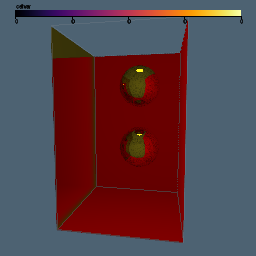

In [11]:
#include <VTKmXeusRender.h>
#pragma cling load("lodepng")
[&]() 
{
auto try_and_err = [&]()
{
  using M = vtkm::rendering::MapperPathTracer;
  using C = vtkm::rendering::CanvasPathTracer;
  using V3 = vtkm::rendering::View3D;
  // using V2 = vtkm::rendering::View2D;

  vtkm::cont::ColorTable colorTable("inferno");


    
  M mapper;
  mapper.SetNumRends(5);
  mapper.SetMaxDepth(6);
  
  C canvas(256,256);

    VTKmXeusRender renderer;
    
    using TupleType = std::tuple<int, int, vtkm::Float32,vtkm::Vec<vtkm::Float32,3>>;
    std::vector<TupleType> vec;
    vec.push_back(std::make_tuple(1024, 1024, 1.0, vtkm::Vec<vtkm::Float32,3>(3,6,3)));
    vec.push_back(std::make_tuple(1024, 1024, 1.0, vtkm::Vec<vtkm::Float32,3>(3,3,3)));
    auto ds = makeScene(vec);//createSphere(1024,1024, vtkm::Vec<vtkm::Float32, 3>(3,3,3));
    std::string fieldNm("cellvar");
    vtkm::rendering::Scene scene;
    auto light = vtkm::rendering::Light(vtkm::rendering::LightType::LightDirectional, 
                                        vtkm::Vec<vtkm::Float32, 3>(1.f, 1.f, 1.f), 
                                        100.f, 0.05f, 
                                        vtkm::Vec<vtkm::Float32, 3>(0,0.9,0));
    scene.AddLight(light);
    
    auto mat = vtkm::rendering::Material(vtkm::rendering::DiffuseSpecular, 
                               vtkm::rendering::SpectrumFromRGB(0.3f,0.3f,0.7f) ,0.4f, 
                               vtkm::rendering::SpectrumFromRGB(1.f,1.f,1.f), 1.41f, 0.05f);
    scene.AddMaterial(mat);

    //obviously don't have access to internal
   //this->Internals->MaterialTF.AddMatTF(0.15f, 5);
    //so we have to AddMatTF this way
    auto mattf = scene.GetTransferFunction();
    mattf.AddMatTF(0.15f, 5);
 
   scene.AddSurface(vtkm::rendering::Surface(vtkm::rendering::MicrofacetBlinn, 1000.f)); //0
    scene.AddSurface(vtkm::rendering::Surface(vtkm::rendering::MicrofacetBlinn, 1.f));    //1
    scene.AddSurface(vtkm::rendering::Surface(vtkm::rendering::MicrofacetBlinn, 1.5f));   //2
    scene.AddSurface(vtkm::rendering::Surface(vtkm::rendering::MicrofacetBlinn, 2.f));    //3
    scene.AddSurface(vtkm::rendering::Surface(vtkm::rendering::MicrofacetBlinn, 100.f));  //4
    scene.AddSurface(vtkm::rendering::Surface(vtkm::rendering::MicrofacetBlinn, 1000.f)); //5

    scene.AddActor(vtkm::rendering::Actor(
    ds.GetCellSet(), ds.GetCoordinateSystem(), ds.GetField(fieldNm), colorTable));
    vtkm::rendering::Camera camera;
    camera = vtkm::rendering::Camera();
    camera.ResetToBounds(ds.GetCoordinateSystem().GetBounds());
    camera.Azimuth(static_cast<vtkm::Float32>(280.0));
    camera.Elevation(static_cast<vtkm::Float32>(5.0));
    //renderer.SetCamera(camera, ds.GetCoordinateSystem().GetBounds(), ds.GetField(fieldNm));

    vtkm::rendering::Color background(0.0f, 1.0f, 1.0f, 1.0f);
    vtkm::rendering::Color foreground(0.0f, 0.0f, 0.0f, 1.0f);
    V3 view(scene, mapper, canvas, camera, background, foreground);

    renderer.Render(view);
    renderer.Display(canvas);
    
};
try_and_err();
}();